In [17]:
%%time
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.inspection import permutation_importance
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
import itertools


CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
%%time
# Load the dataset
df = pd.read_csv('stress_data.csv')
df.head()

# Preliminary statistical analysis
stats = df.describe().transpose()
stats['skew'] = df.skew()
stats['kurtosis'] = df.kurtosis()
print(stats)

<timed exec>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:7: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


            count       mean        std     min        25%        50%  \
X      11509051.0 -28.237747  31.423101 -128.00 -52.000000 -33.000000   
Y      11509051.0  -0.909103  33.433819 -128.00 -19.000000   1.000000   
Z      11509051.0  23.824486  29.853173 -128.00   4.000000  25.000000   
EDA    11509051.0   3.502127   5.656541    0.00   0.224206   1.157407   
HR     11509051.0  85.760902  14.196415   51.00  76.720000  83.900000   
TEMP   11509051.0  32.234345   2.260516   24.09  30.190000  32.570000   
label  11509051.0   1.554202   0.789183    0.00   1.000000   2.000000   

             75%         max      skew   kurtosis  
X     -14.000000  127.000000  0.966240   0.848937  
Y      17.000000  127.000000 -0.206264  -0.067435  
Z      49.000000  127.000000 -0.349053   0.254031  
EDA     4.077436   59.760712  3.026141  12.169553  
HR     93.100000  180.230000  0.927843   2.327563  
TEMP   34.250000   36.590000 -0.282816  -1.088713  
label   2.000000    2.000000 -1.325510  -0.081319  

<timed exec>:8: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


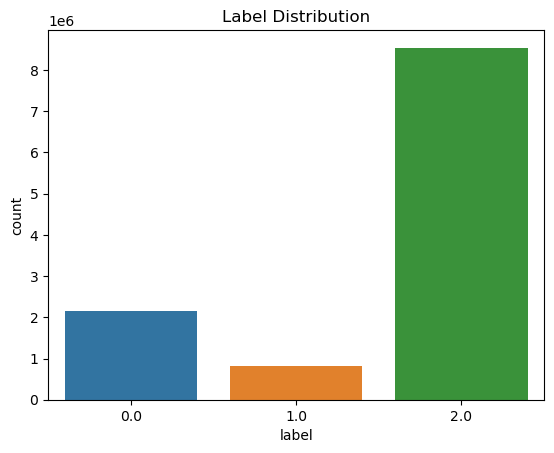

CPU times: total: 312 ms
Wall time: 959 ms


In [50]:
%%time
Correlation matrix excluding 'id' and 'datetime'
corr_matrix = df.drop(['id', 'datetime'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Distribution of labels
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.show()

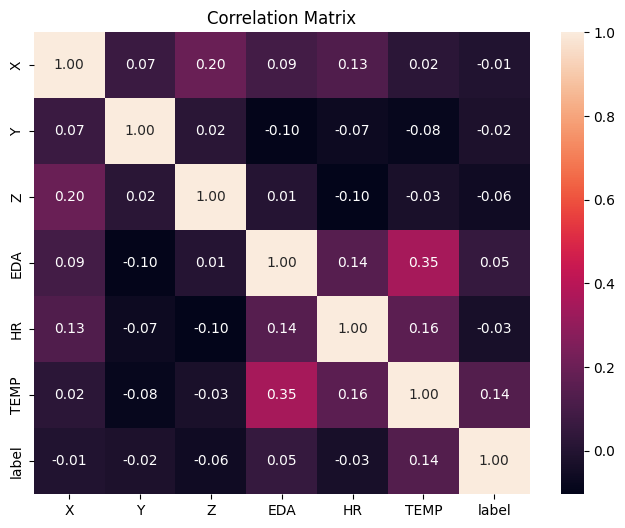

In [13]:
%%time
# Handle missing values (if any)
df.fillna(df.median(), inplace=True)

# Feature scaling
features = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Preparing the dataset
X = df[features]
y = df['label']

<timed exec>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


CPU times: total: 4.03 s
Wall time: 10.4 s


Original Label Distribution:
 2.0    8540583
0.0    2162246
1.0     806222
Name: label, dtype: int64

Label distribution after undersampling and applying SMOTE:
0.0    2162246
1.0    2162246
2.0    2162246
Name: label, dtype: int64


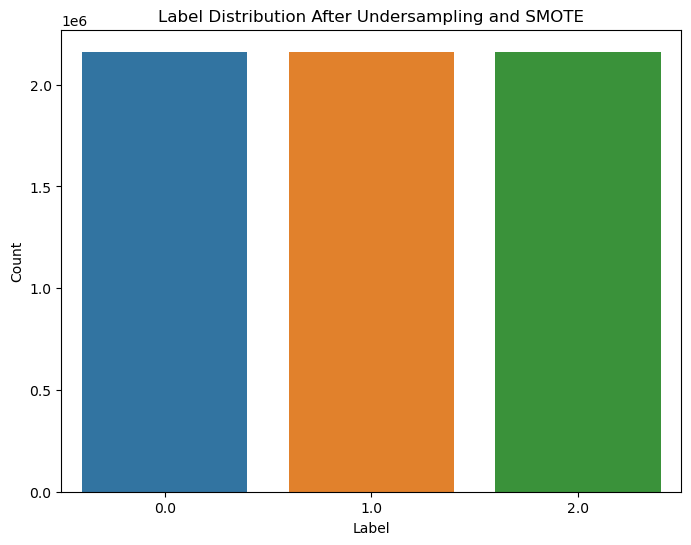

CPU times: total: 59.5 s
Wall time: 2min 41s


In [14]:
%%time
# Original label distribution
print("Original Label Distribution:\n", y.value_counts())

# Undersampling the majority class
undersample_strategy = {2.0: 2000000}  # Adjust the number as needed
undersampler = RandomUnderSampler(sampling_strategy=undersample_strategy)
X_under, y_under = undersampler.fit_resample(X, y)

# Applying SMOTE to the undersampled data
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_under, y_under)

print("\nLabel distribution after undersampling and applying SMOTE:")
print(y_res.value_counts())

# Visualizing label distribution after undersampling and applying SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_res)
plt.title('Label Distribution After Undersampling and SMOTE')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)


Model: RandomForestClassifier
Accuracy: 0.9934199099496306
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    648556
         1.0       1.00      0.99      0.99    649449
         2.0       0.99      0.99      0.99    648017

    accuracy                           0.99   1946022
   macro avg       0.99      0.99      0.99   1946022
weighted avg       0.99      0.99      0.99   1946022

ROC-AUC: 0.9998676251875752



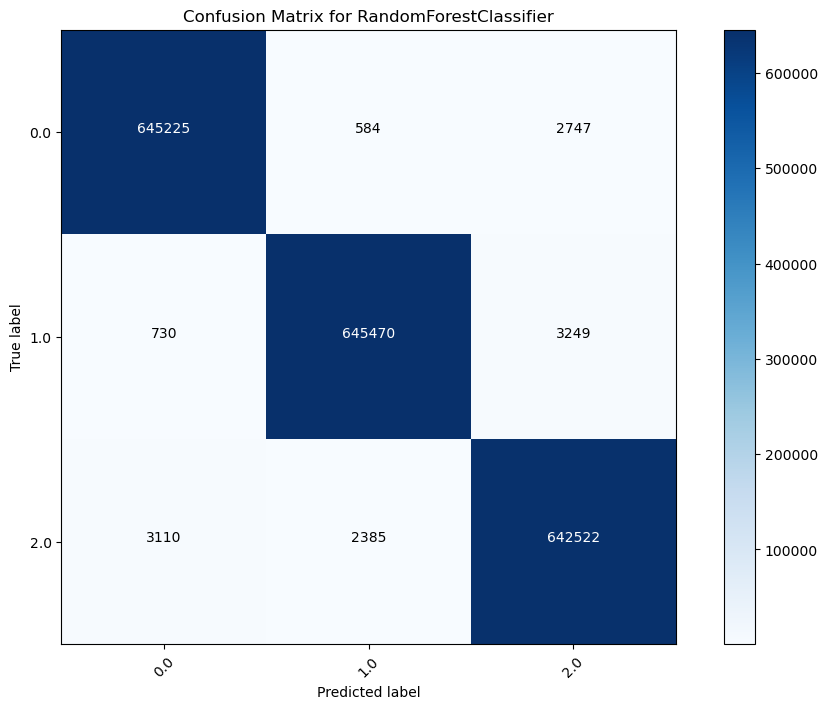

C:\Users\anays\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Model: XGBClassifier
Accuracy: 0.883350753485829
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88    648556
         1.0       0.90      0.92      0.91    649449
         2.0       0.87      0.85      0.86    648017

    accuracy                           0.88   1946022
   macro avg       0.88      0.88      0.88   1946022
weighted avg       0.88      0.88      0.88   1946022

ROC-AUC: 0.9757675007454724



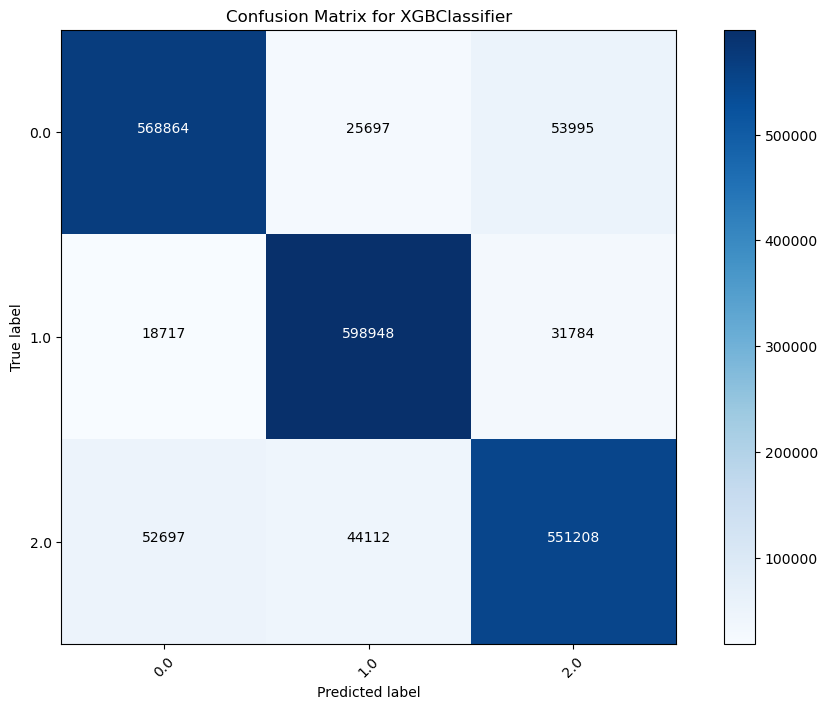

Model: MLPClassifier
Accuracy: 0.7348169753476579
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.74      0.73    648556
         1.0       0.78      0.77      0.77    649449
         2.0       0.70      0.70      0.70    648017

    accuracy                           0.73   1946022
   macro avg       0.73      0.73      0.73   1946022
weighted avg       0.73      0.73      0.73   1946022

ROC-AUC: 0.8978676989050117



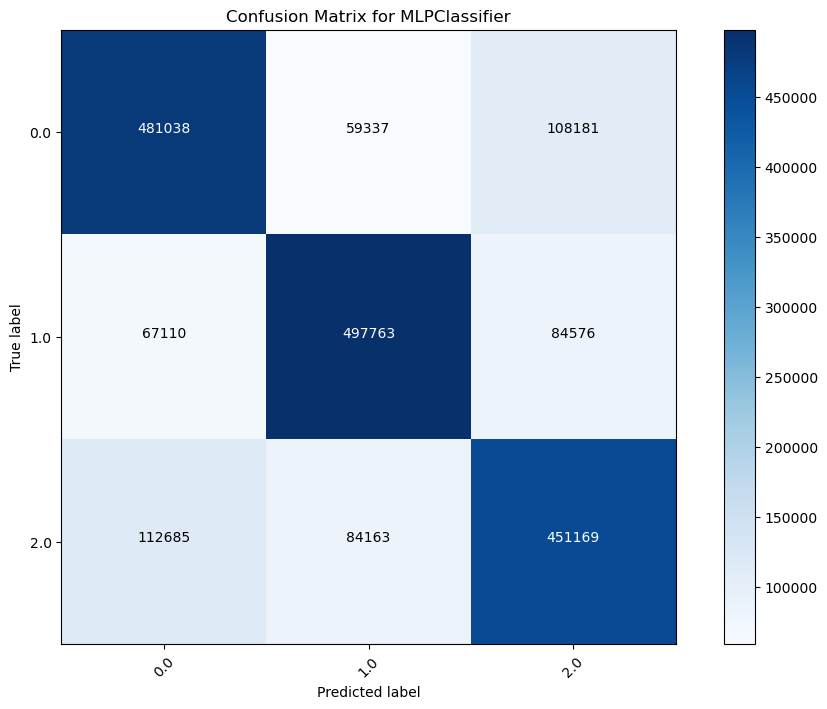

CPU times: total: 2h 15min 50s
Wall time: 41min 15s


In [18]:
%%time

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.figure(figsize=(10, 7))  # Make the figure larger
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # For ANN, predict_proba might not be available, handle it separately
    if hasattr(model, 'predict_proba'):
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovo')
    else:
        roc_auc = 'Not Applicable for ANN'

    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(class_report)
    print(f"ROC-AUC: {roc_auc}\n")

    # Plotting the confusion matrix
    # plt.figure()
    plot_confusion_matrix(conf_matrix, classes=['0.0', '1.0', '2.0'], title=f'Confusion Matrix for {model.__class__.__name__}')

# Random Forest
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
evaluate_model(rf, X_train, y_train, X_test, y_test)

# XGBoost
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, use_label_encoder=False, eval_metric='mlogloss')
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

# Artificial Neural Network
ann = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200)
evaluate_model(ann, X_train, y_train, X_test, y_test)

C:\Users\anays\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


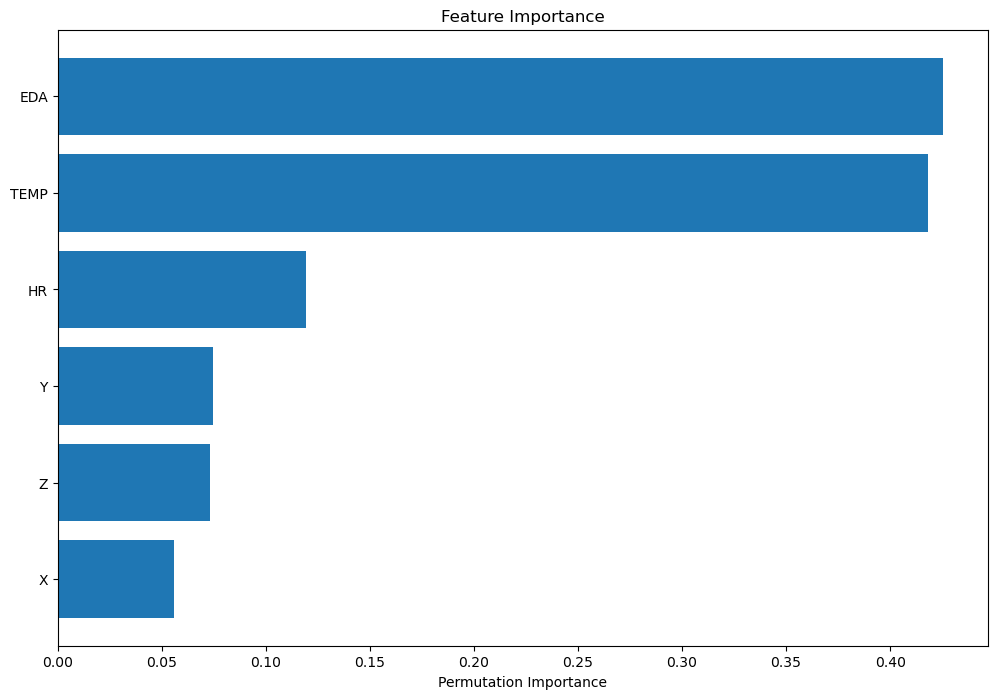

CPU times: total: 33min 28s
Wall time: 8min 54s


In [19]:
%%time

model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)  # Make sure the model is already trained

# Calculate permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Sorting the importances
sorted_idx = perm_importance.importances_mean.argsort()

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()

C:\Users\anays\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\anays\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\anays\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Model: StackingClassifier
Accuracy: 0.9942045876151452
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    648556
         1.0       1.00      0.99      1.00    649449
         2.0       0.99      0.99      0.99    648017

    accuracy                           0.99   1946022
   macro avg       0.99      0.99      0.99   1946022
weighted avg       0.99      0.99      0.99   1946022

ROC-AUC: 0.9998722361215356



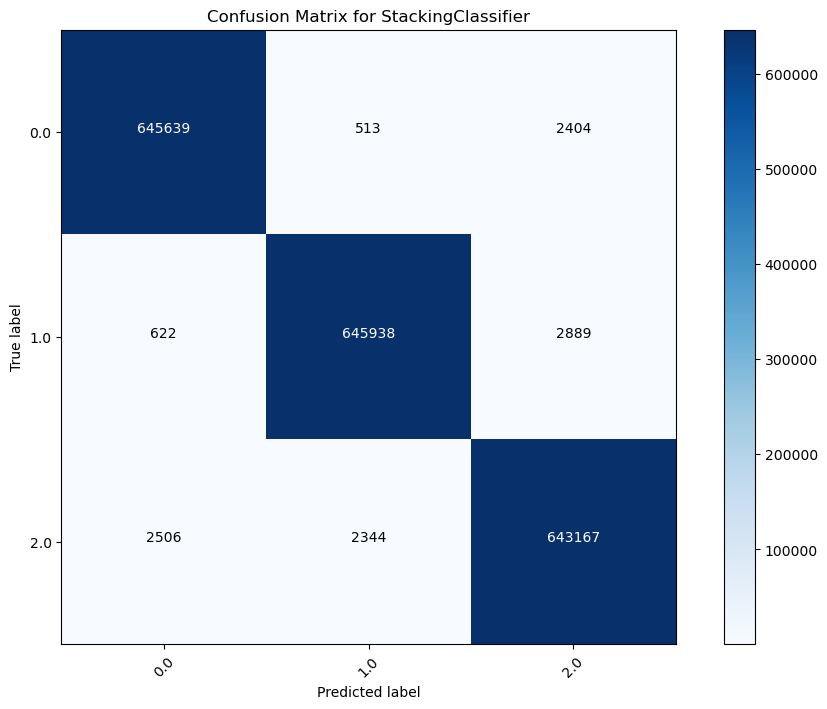

CPU times: total: 9h 18min 35s
Wall time: 4h 4min 44s


In [20]:
%%time

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define the Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_model), ('ann', ann)],
    final_estimator=LogisticRegression(),
    passthrough=True
)

# Evaluate the Stacking Classifier
evaluate_model(stacking_clf, X_train, y_train, X_test, y_test)

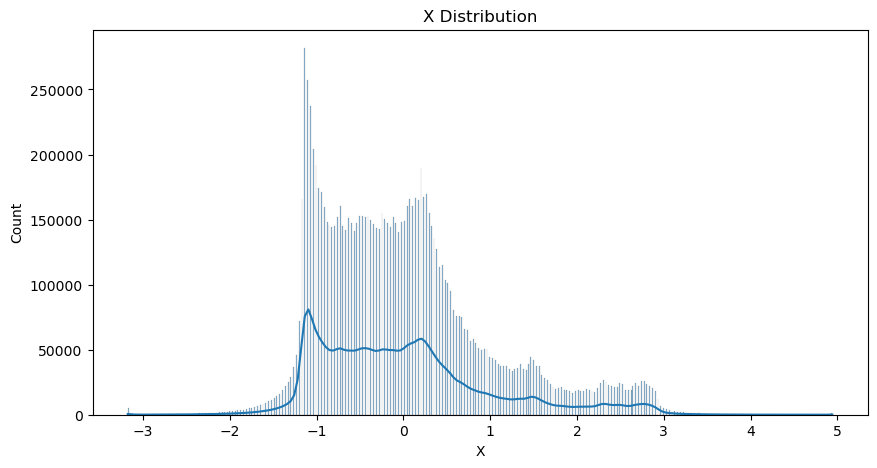

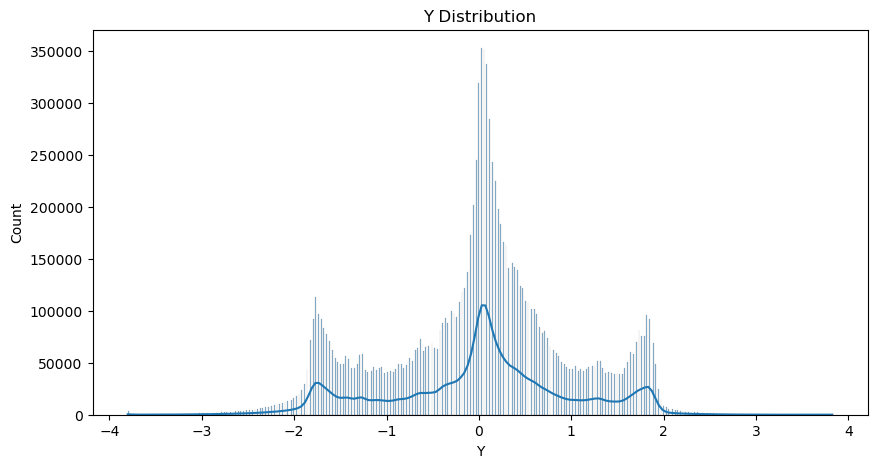

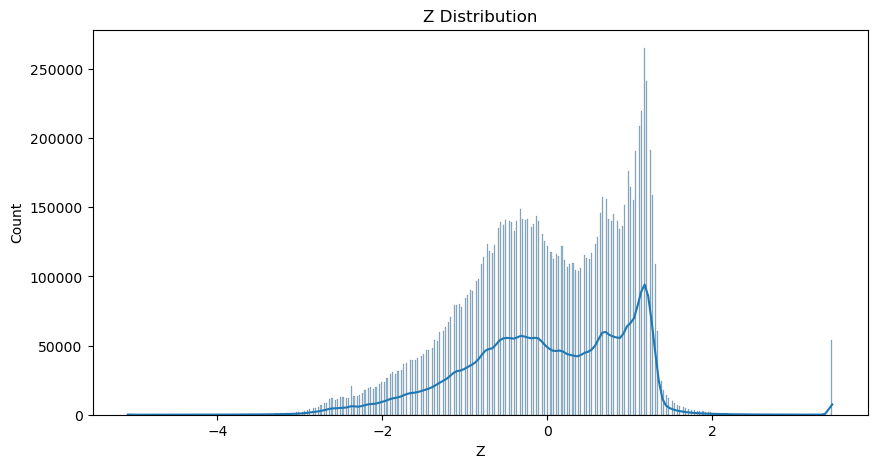

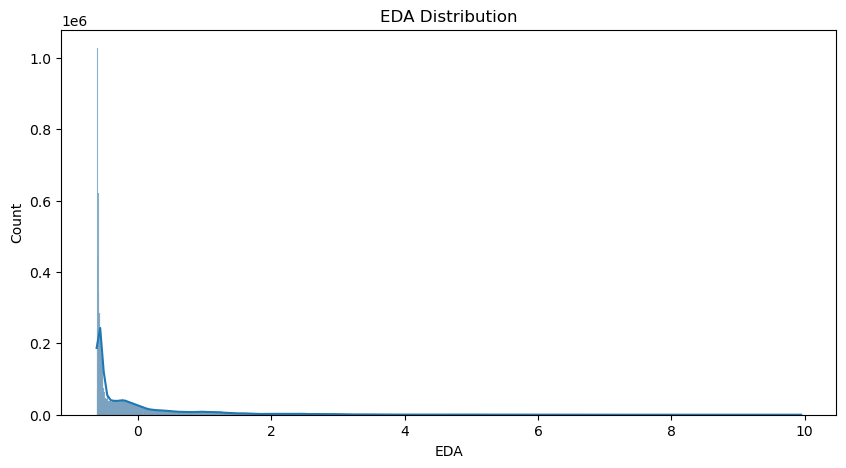

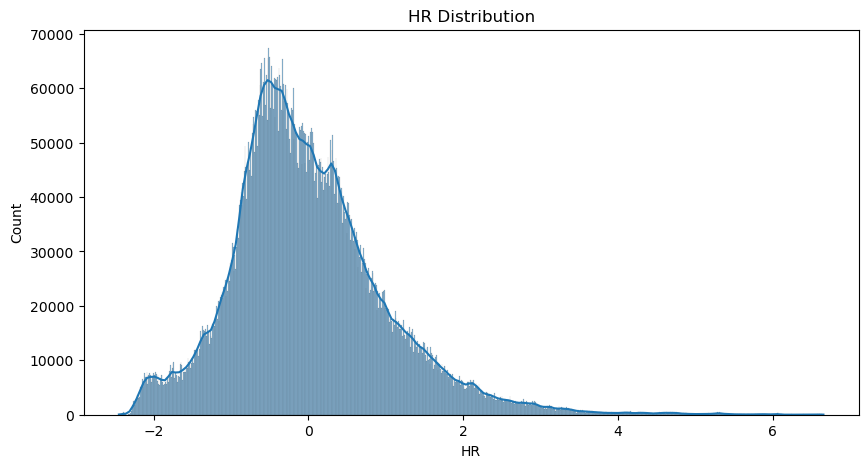

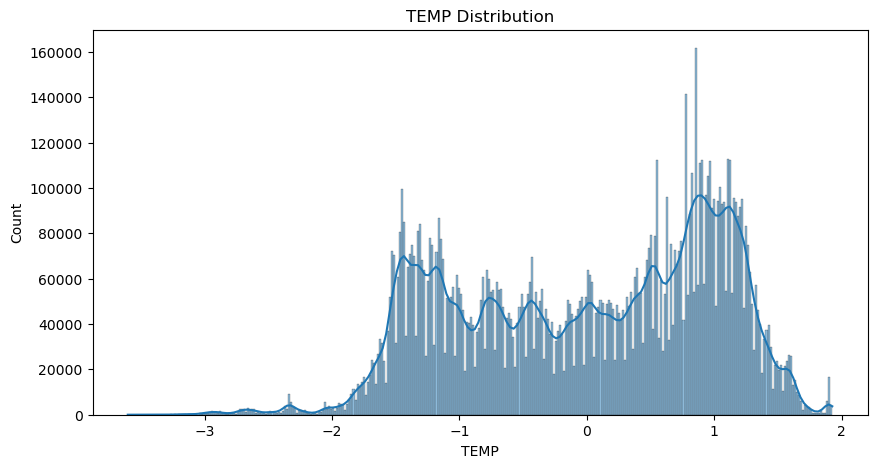

In [21]:
# Additional visualizations as needed, e.g., feature distributions, ROC curves

features = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP']
for feature in features:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f'{feature} Distribution')
    plt.show()

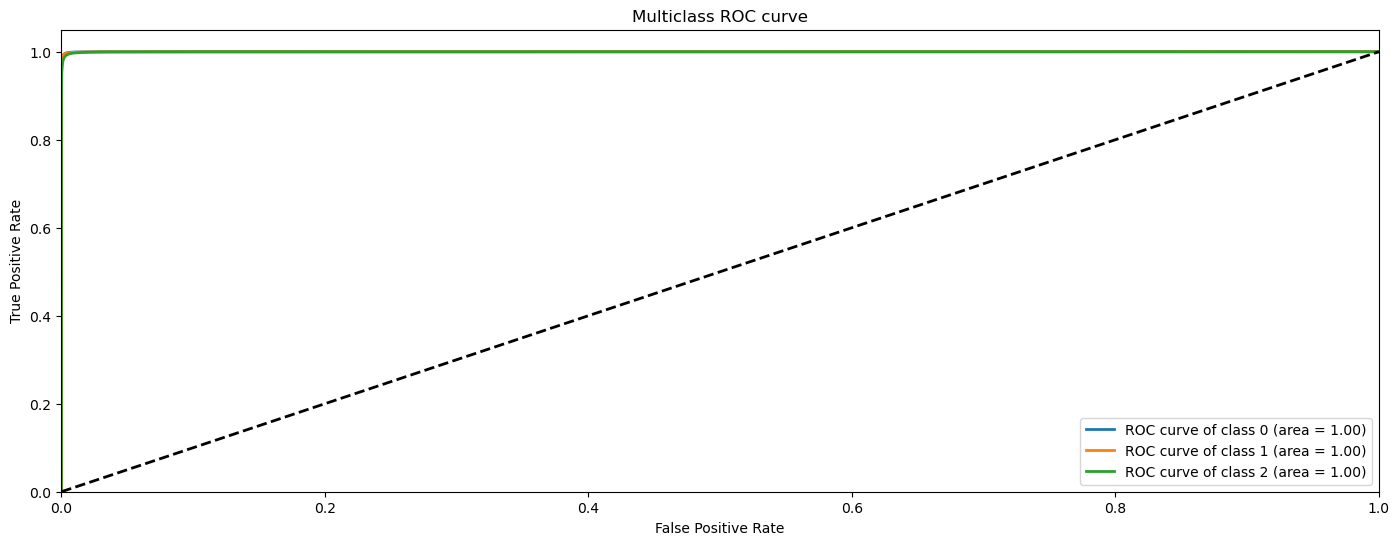

CPU times: total: 2min 42s
Wall time: 35.7 s


In [22]:
%%time

from sklearn.metrics import roc_curve, auc

# Function to plot ROC curves for each class
def plot_multiclass_roc(model, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = model.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting
    plt.figure(figsize=figsize)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Assuming 'stacking_clf' is your trained Stacking Classifier
plot_multiclass_roc(stacking_clf, X_test, y_test, n_classes=3)

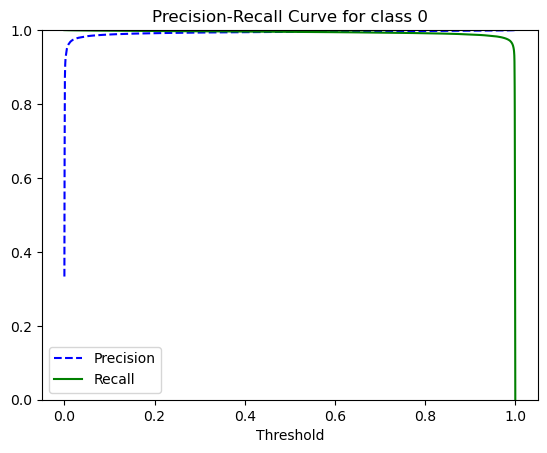

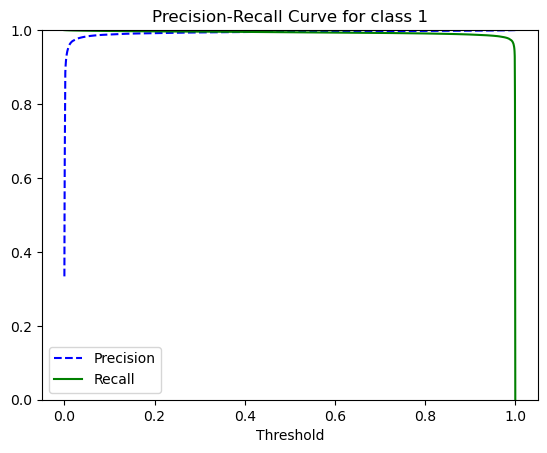

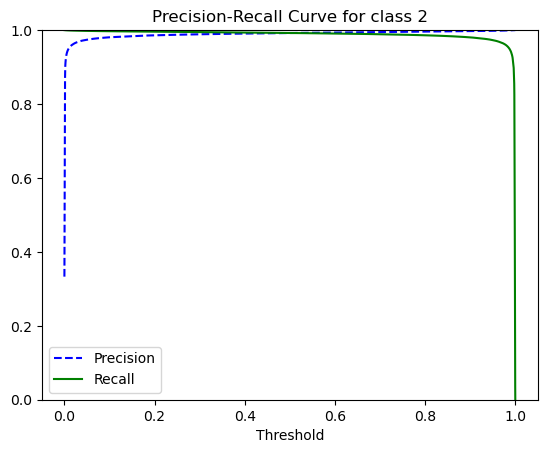

CPU times: total: 8min 9s
Wall time: 1min 47s


In [23]:
%%time

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Function to plot Precision-Recall curves for each class
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, title='Precision-Recall vs Threshold'):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.ylim([0, 1])
    plt.title(title)

for i in range(y_test.nunique()):
    precision, recall, thresholds = precision_recall_curve(y_test == i, stacking_clf.predict_proba(X_test)[:, i])
    plot_precision_recall_vs_threshold(precision, recall, thresholds, title=f'Precision-Recall Curve for class {i}')
    plt.show()


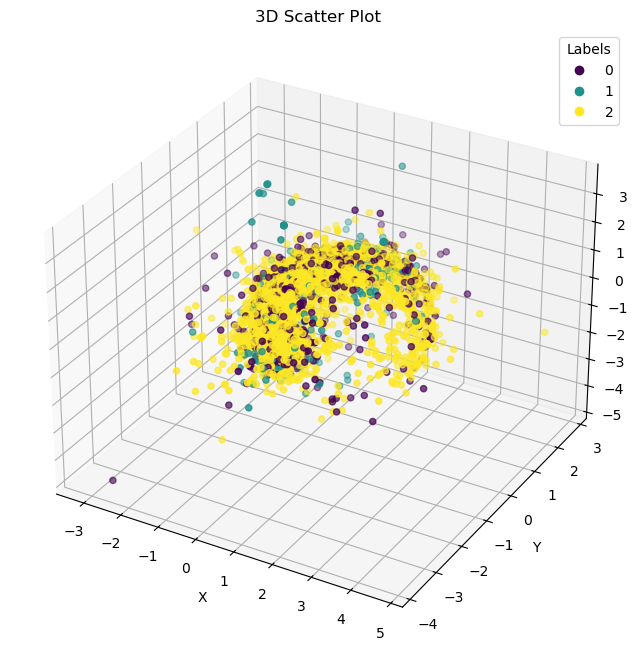

In [24]:
from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting a sample of the data to avoid overplotting
sample_df = df.sample(n=5000, random_state=42)
scatter = ax.scatter(sample_df['X'], sample_df['Y'], sample_df['Z'], c=sample_df['label'], cmap='viridis')

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Scatter Plot')
plt.legend(*scatter.legend_elements(), title="Labels")
plt.show()


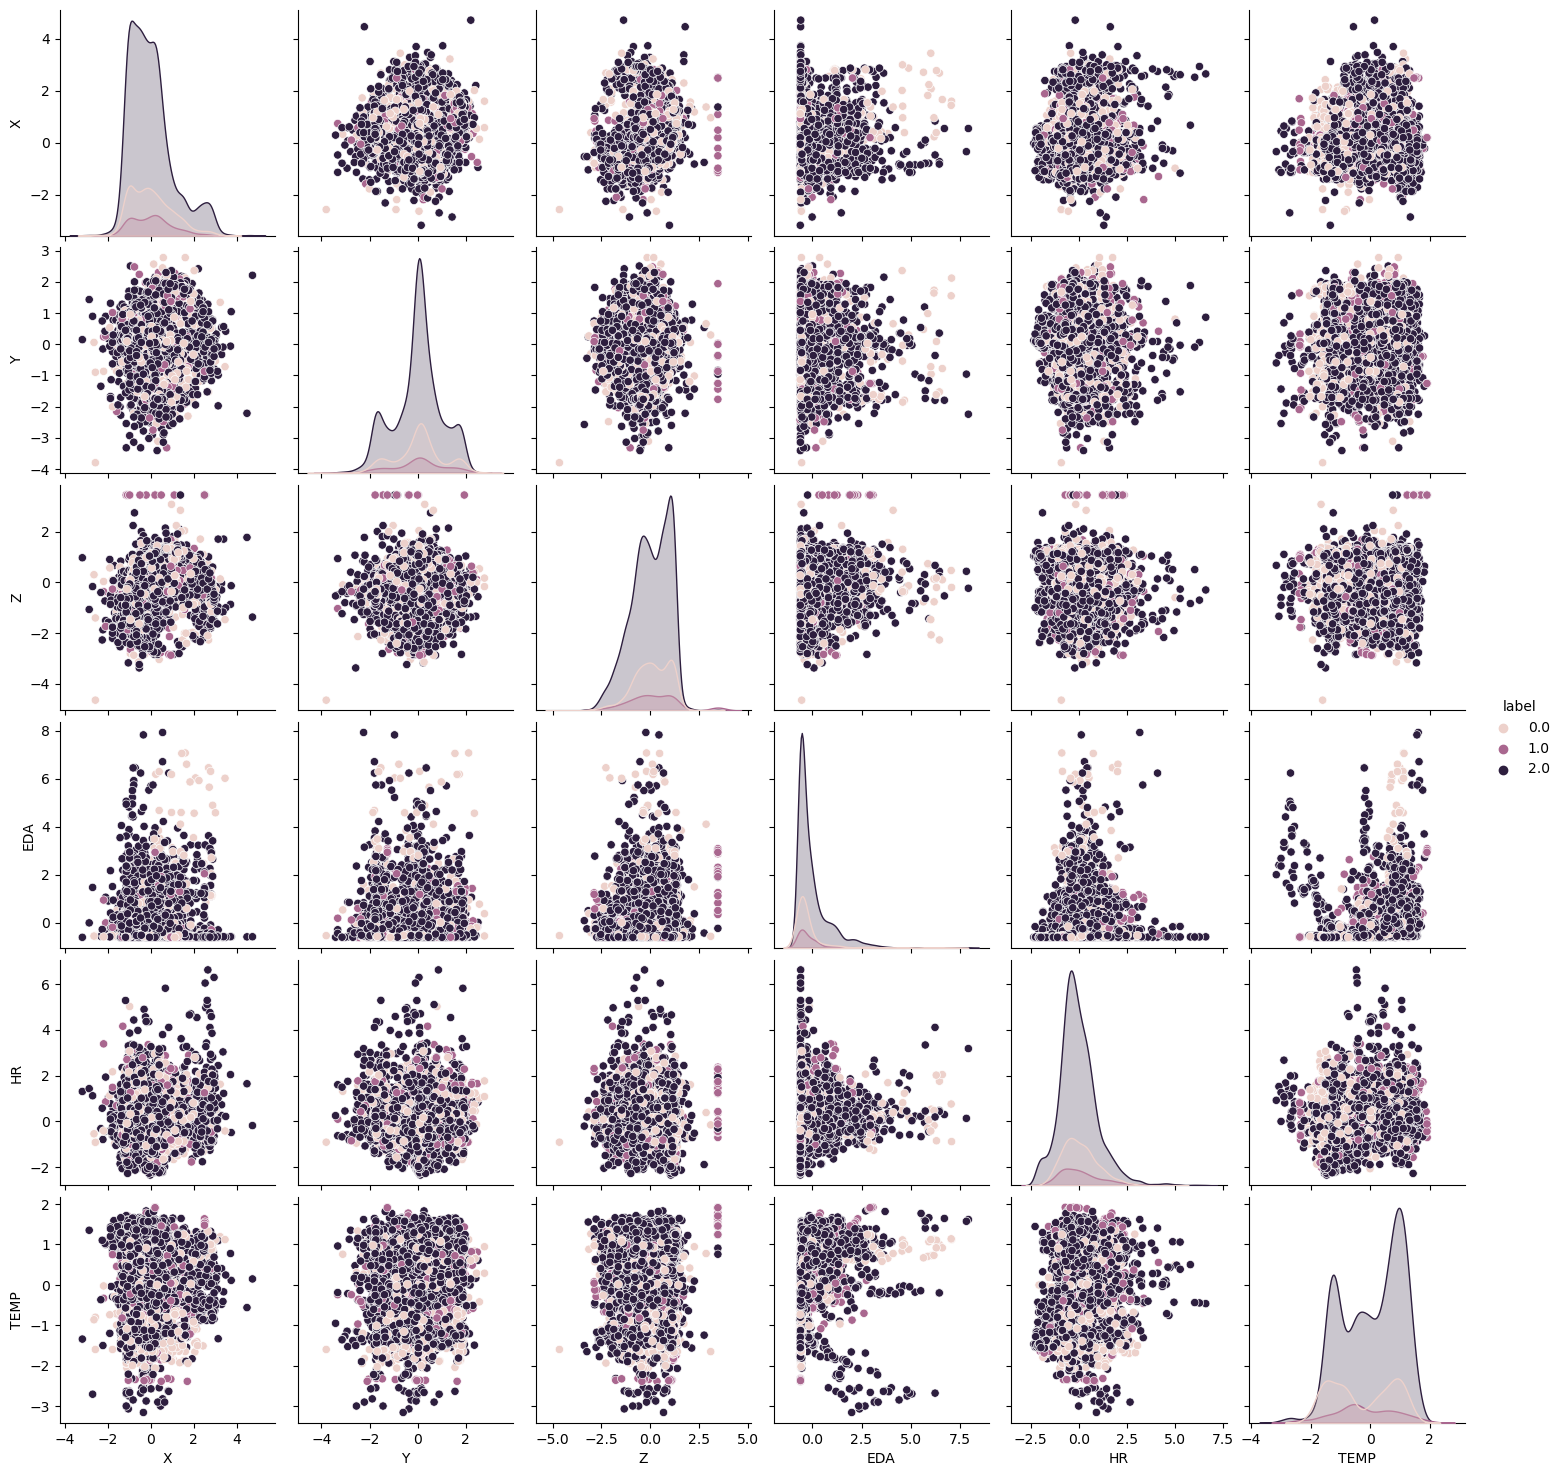

In [25]:
# Pair plot for a sample of data
# Using a sample to reduce overplotting
sample_df = df.sample(n=5000, random_state=42)
sns.pairplot(sample_df, hue='label', vars=['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP'])
plt.show()

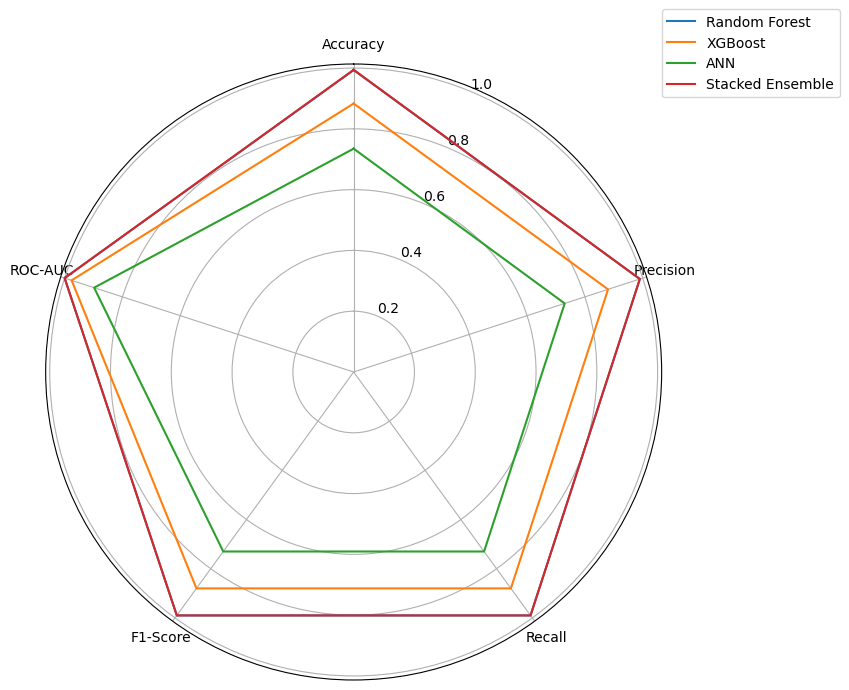

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with the performance metrics for each model
metrics_dict = {
    'Random Forest': {
        'Accuracy': 0.9934199099496306,
        'Precision': 0.99,
        'Recall': 0.99,
        'F1-Score': 0.99,
        'ROC-AUC': 0.9998676251875752
    },
    'XGBoost': {
        'Accuracy': 0.883350753485829,
        'Precision': 0.88,
        'Recall': 0.88,
        'F1-Score': 0.88,
        'ROC-AUC': 0.9757675007454724
    },
    'ANN': {
        'Accuracy': 0.7348169753476579,
        'Precision': 0.73,
        'Recall': 0.73,
        'F1-Score': 0.73,
        'ROC-AUC': 0.8978676989050117
    },
    'Stacked Ensemble': {
        'Accuracy': 0.9942045876151452,
        'Precision': 0.99,
        'Recall': 0.99,
        'F1-Score': 0.99,
        'ROC-AUC': 0.9998722361215356
    }
}

# Convert the dictionary into a DataFrame
metrics_df = pd.DataFrame(metrics_dict).T

# Create a radar chart for model comparison
labels=np.array(['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

# Number of variables we're plotting
num_vars = len(labels)

# Calculate angles array for the plot
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Plot each model's performance on the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one line per model
for index, row in metrics_df.iterrows():
    data = row.tolist()
    data += data[:1]  # repeat the first value to close the circle
    ax.plot(angles, data, label=index)

# Add labels to the plot
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


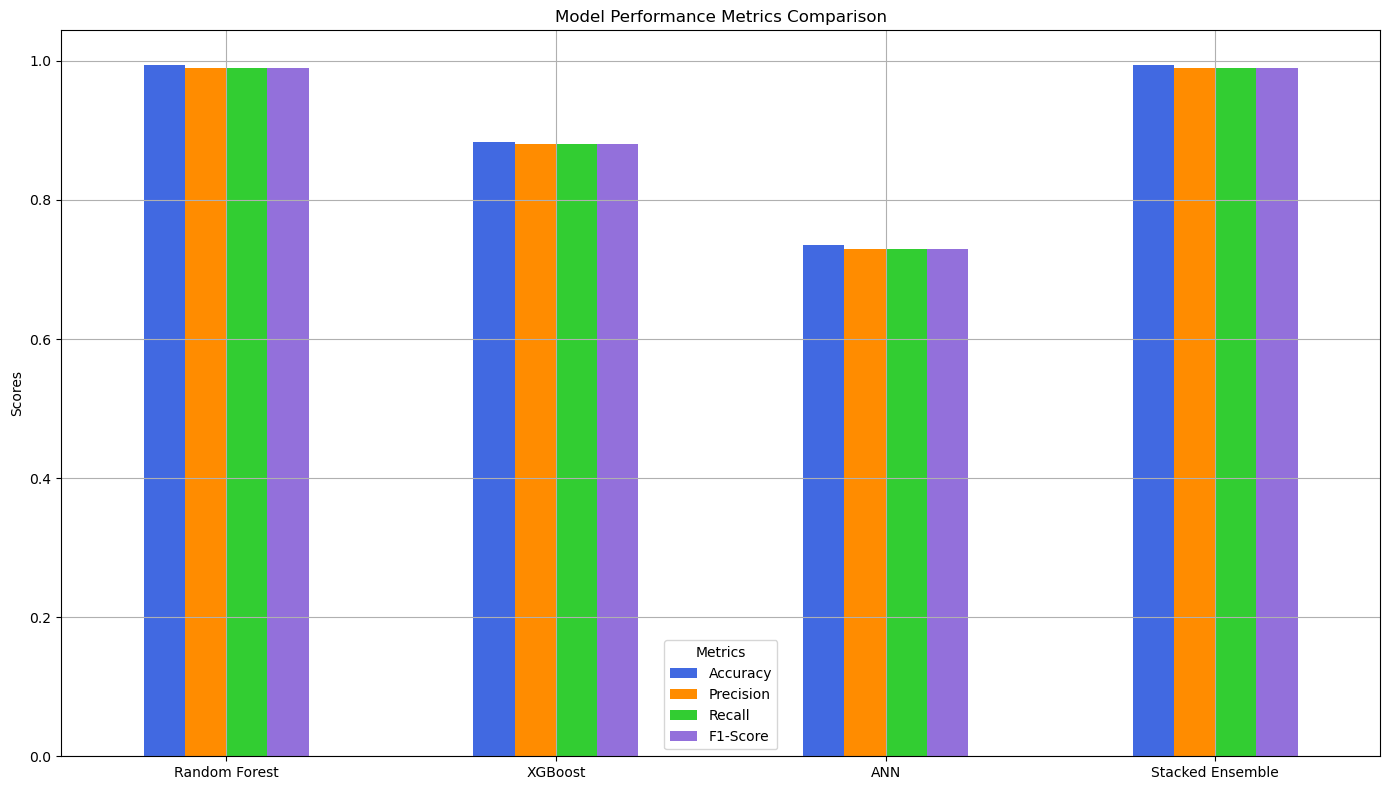

In [35]:
# Grouped bar chart
# Define a custom color palette
colors = ['royalblue', 'darkorange', 'limegreen', 'mediumpurple']

# Grouped bar chart with custom color palette
ax = metrics_df.drop('ROC-AUC', axis=1).plot(kind='bar', figsize=(14, 8), color=colors)
plt.title('Model Performance Metrics Comparison')
plt.ylabel('Scores')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()


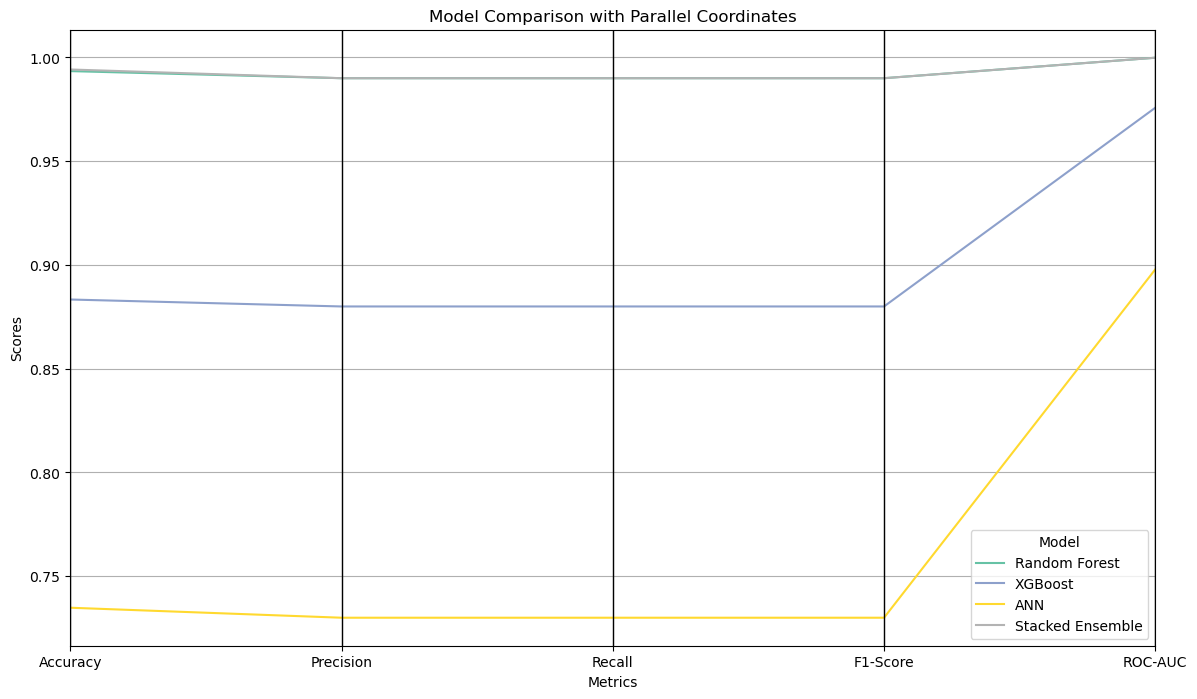

In [37]:
from pandas.plotting import parallel_coordinates

# First, add the 'Model' column to the DataFrame
metrics_df['Model'] = metrics_df.index

# Now create the parallel coordinates plot
plt.figure(figsize=(14, 8))
parallel_coordinates(metrics_df, 'Model', colormap=plt.get_cmap("Set2"))
plt.title('Model Comparison with Parallel Coordinates')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.legend(title='Model')
plt.grid(True)
plt.show()


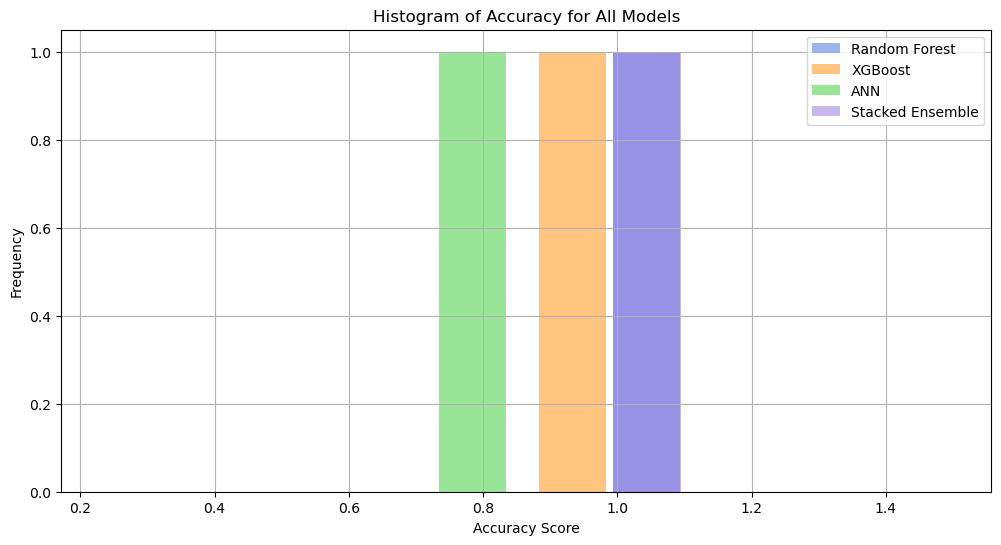

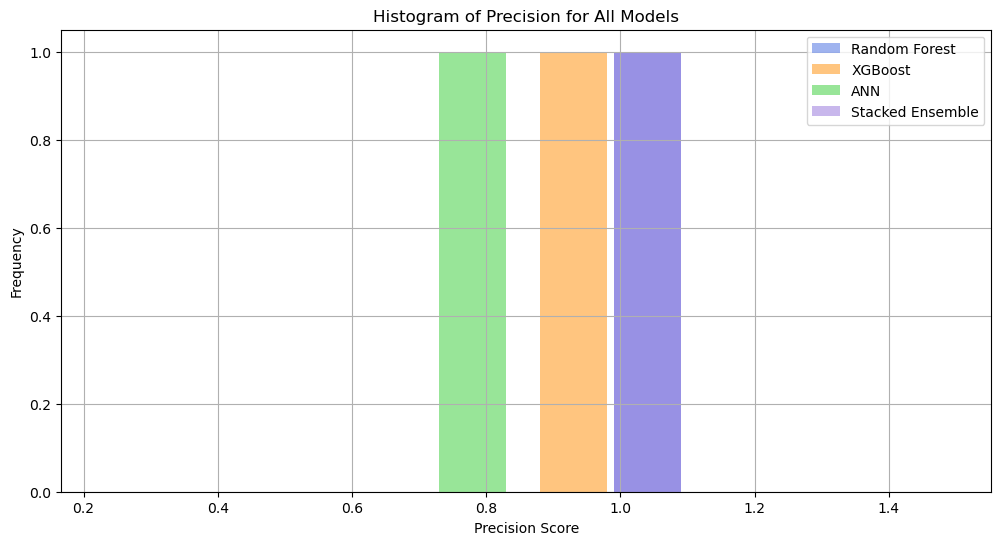

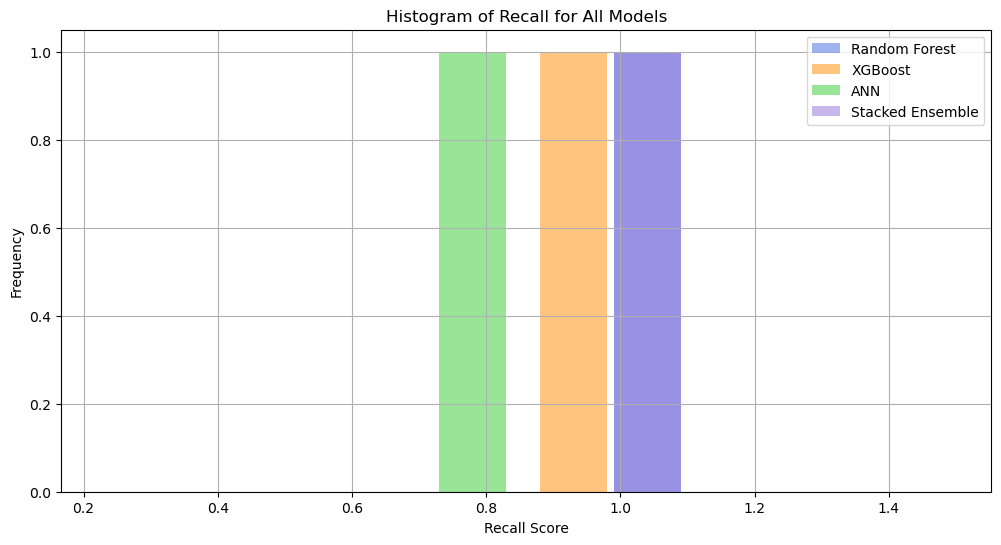

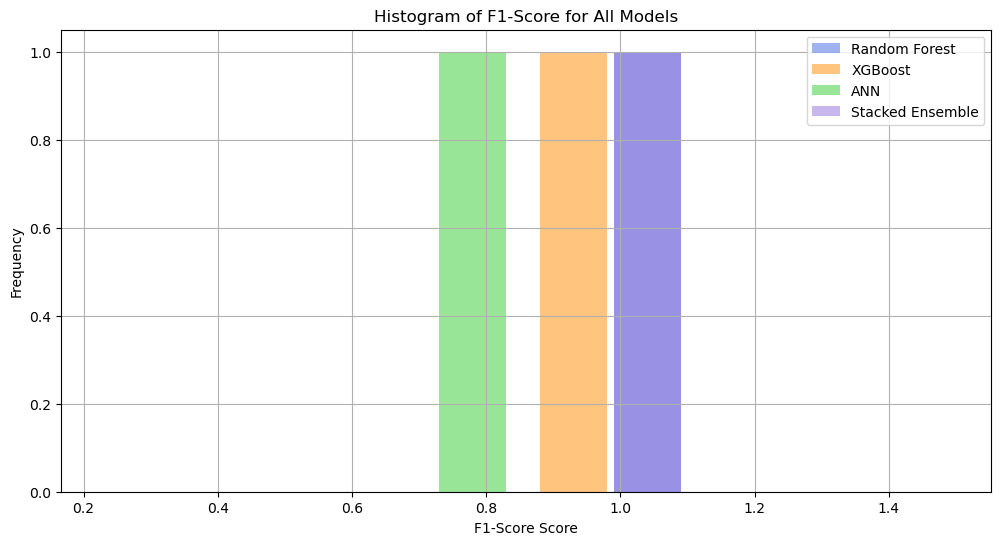

In [44]:
import matplotlib.pyplot as plt

# Define a translucent color palette
colors = ['royalblue', 'darkorange', 'limegreen', 'mediumpurple']

# Iterate over each metric and plot a histogram for all models
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score']):  # List all metrics here
    plt.figure(figsize=(12, 6))

    # Plot a histogram for each model for the current metric
    for j, model in enumerate(metrics_df.index):
        plt.hist(metrics_df.at[model, metric], bins=10, alpha=0.5, color=colors[j], label=model)

    plt.xlabel(f'{metric} Score')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {metric} for All Models')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


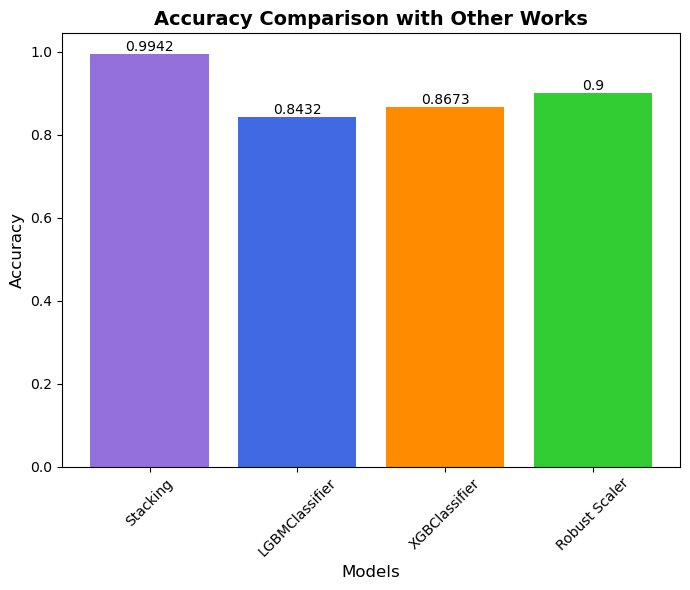

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Your results
your_results = pd.DataFrame({
    'Model': ['Stacking'],
    'Accuracy': [0.9942]
})

# Other researchers' results
others_results = pd.DataFrame({
    'Model': ['LGBMClassifier', 'XGBClassifier', 'Robust Scaler'],
    'Accuracy': [0.843198, 0.867347, 0.90]
})

# Combine your results and others' results
all_results = pd.concat([your_results, others_results]).reset_index(drop=True)

# Define the color scheme
colors = ['mediumpurple', 'royalblue', 'darkorange', 'limegreen']

# Create a bar chart with the new color scheme
plt.figure(figsize=(7, 6))
bars = plt.bar(all_results['Model'], all_results['Accuracy'], color=colors)

# Add a legend
# plt.legend(bars, all_results['Model'])

# Add titles and labels with a style
plt.title('Accuracy Comparison with Other Works', fontsize=14, fontweight='bold')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom', ha='center', fontsize=10)

plt.tight_layout()  # Adjust layout to fit all elements
plt.show()
